<a href="https://colab.research.google.com/github/MayMagician/ps2classification/blob/main/ps2classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MobileNetV2 classifier to identify PS2 games**

- Introduction and idea behind the project: [README.md](README.md).
- Informations about the games and classes uses for the demonstration: [gamesInfo.md](gamesInfo.md).
- Support Python script to obtain the screenshots from videos: [imagesGenerator.py](imagesGenerator.py).
- Demonstration dataset contained in the [dataset](https://drive.google.com/drive/folders/1gBj2DjzTyJNX9UlWPW6wuMb2u1oX2fvM?hl=it) folder.
- For informations or support, feel free to reach out: [framay909@gmail.com](mailto:framay909@gmail.com).

This code was run on Google Colaboratory, with the dataset being uploaded on Google Drive. Running it locally is still possible, but not recommended due to the dataset size.

# **0. Setup**

In [1]:
import os

#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

#accessing the path of this notebook, being the folder containing the project
notebook_path = "/content/drive/MyDrive/PS2Project"
os.chdir(notebook_path)

#checking if everything went fine (all files in the PS2Project folder should appear)
!ls

Mounted at /content/drive
'Copia di ps2classification.ipynb'   dataset_old
 dataset			     ps2classification.ipynb


In [2]:
#importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shutil
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# **1. Loading and pre-processing**

Loading the dataset, organizing it in batches to simplify the process.

Base pre-processing, re-sizing the images and verifying classes and labels.

Base visualization.

Copying dataset to Colab local memory...
Dataset successfully copied in: /content/dataset
Confirmed subfolders: ['train', 'val', 'test']
Found 3501 files belonging to 5 classes.
Found 750 files belonging to 5 classes.
Found 750 files belonging to 5 classes.
Checking informations about the training dataset...
 
---
 
Classes: ['ffx', 'gow', 'gt4', 'kh', 'sotc']
Number of classes: 5
 
---
 
Images shape: (64, 224, 224, 3)
Labels shape: (64,)
Labels value: [3 1 3 1 0 0 0 1 4 1 3 1 0 0 3 0 4 4 2 1 4 2 4 1 0 2 2 0 2 4 0 0 4 3 2 3 4
 4 1 4 2 3 3 1 1 1 3 3 2 1 0 4 0 4 4 2 1 4 3 4 0 3 1 3]
Example of images and their corresponding label from the first batch:


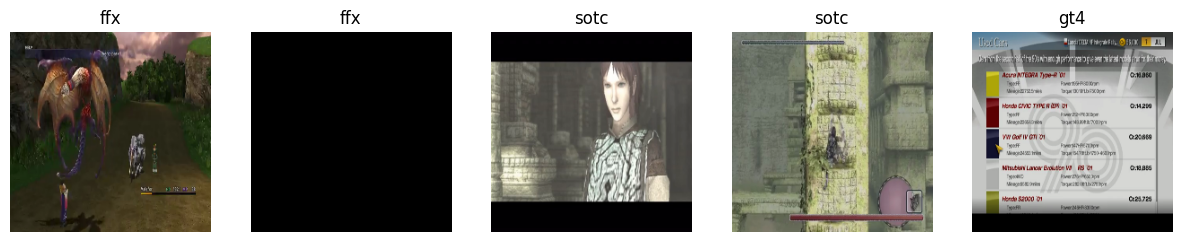

 
---
 
Total number of images: 3501


In [3]:
#loading my dataset

src_path = "/content/drive/MyDrive/PS2Project/dataset"
dst_path = "/content/dataset"

print("Copying dataset to Colab local memory...")

#copies dataset to local memory
if not os.path.exists(dst_path): #check if already exists
    shutil.copytree(src_path, dst_path)
    print(f"Dataset successfully copied in: {dst_path}")
else:
    print(f"Dataset already exists in: {dst_path}")

#verifies if correct subfolders train, val and test exist
expected_subfolders = ["train", "val", "test"]
missing = [f for f in expected_subfolders if not os.path.exists(os.path.join(dst_path, f))]
if missing:
    print("Following folders are missing:", missing)
else:
    print("Confirmed subfolders:", expected_subfolders)

#hyperparameters
imagesize = (224, 224) #the most compatible size of the images
batchsize = 64

train_ds = image_dataset_from_directory(
    os.path.join(dst_path, "train"),
    image_size=imagesize,
    batch_size=batchsize
)

#saving the class names so that I can use them for val and test
class_names = train_ds.class_names

val_ds = image_dataset_from_directory(
    os.path.join(dst_path, "val"),
    image_size=imagesize,
    batch_size=batchsize,
    class_names=class_names,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    os.path.join(dst_path, "test"),
    image_size=imagesize,
    batch_size=batchsize,
    class_names=class_names,
    shuffle=False
)

print("Checking informations about the training dataset...")

print(" ")
print("---")
print(" ")

#classes
class_names = train_ds.class_names
print("Classes:", class_names) #should be a list of strings, being the class names
print("Number of classes:", len(class_names)) #should be the number of different classes

print(" ")
print("---")
print(" ")

#batches
for images, labels in train_ds.take(1):  #take the first batch in order to check
    print("Images shape:", images.shape) #should be (batchsize, imagesize, 3) - 3 is the standard number of RGB channels
    print("Labels shape:", labels.shape) #should be (batchsize,) - 1-dimensional tuple
    print("Labels value:", labels.numpy()) #should be a list of labels of len = batchsize. numeric indices corresponding to class_names
#print images and labels of the first batch
print("Example of images and their corresponding label from the first batch:")
for images, labels in train_ds.take(1):
    first_batch_images = images #saving the images so that they can be called again later
    first_batch_labels = labels #saving the labels so that they can be called again later
    num_to_show = min(5, batchsize)  #shows a number of images equal to the minimum between 5 and batch size

    plt.figure(figsize=(15,3))
    for i in range(num_to_show):
        ax = plt.subplot(1, num_to_show, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

print(" ")
print("---")
print(" ")

#total number of images
num_images = 0
for batch in train_ds:
    num_images += batch[0].shape[0]
print("Total number of images:", num_images) #should be the total number of images in the dataset

# **2. Data augmentation**

Initializing data augmentation for training; the idea is to include the data_augmentation layer as the first layer of the Transfer Learning model, before the base model.

In this way, each batch is randomly modified according to the defined rules, so that in each epoch the model is trained on slightly different versions of the original images. This helps reduce overfitting.

Please note that this step can be skipped if the dataset is large enough.

Providing an example of applied subsequential transformation...
 
---
 
Previously loaded images with data augmentation applied:


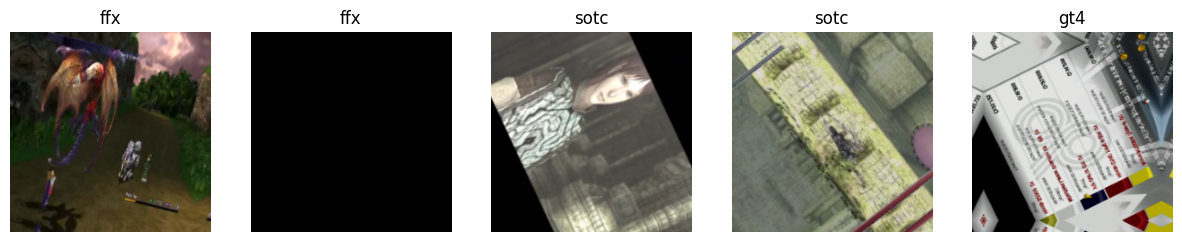

In [4]:
#hyperparameters
flipMode = "horizontal" #could be "horizontal", "vertical" or "horizontal_and_vertical". horizontal is the most coherent for videogames
rotationPercent = 0.2 #maximum angle of rotation for the random rotation ()
randomZoom = 0.2 #maximum percentage of zoom for random zoom
randomContrast = 0.2 #maximum percentage of random contrast

#building the data_augmentation layer
data_augmentation = tf.keras.Sequential([ #applies a series of subsequential transformations
    layers.RandomFlip(flipMode), #randomly flips the image
    layers.RandomRotation(rotationPercent), #rotates the image of a random angle between -rotationPercent% and +rotationPercent% of 360
    layers.RandomZoom(randomZoom), #zooms on the images by randomZoom%
    layers.RandomContrast(randomContrast), #changes the contrast of the image of a random percentage between -randomContrast% and +randomContrast%
], name = "data_augmentation")

print("Providing an example of applied subsequential transformation...")

print(" ")
print("---")
print(" ")

print("Previously loaded images with data augmentation applied:")
augmented_images = data_augmentation(first_batch_images)  #applies data augmentation to the previously saved batch
num_to_show = min(5, batchsize)  #as before, #shows a number of images equal to the minimum between 5 and batch size

plt.figure(figsize=(15,3))
for i in range(num_to_show):
    ax = plt.subplot(1, num_to_show, i+1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[first_batch_labels[i]]) #refers to the previously saved labels
    plt.axis("off")
plt.show()

# **3. Transfer Learning model**

Building a Transfer Learning model using a pre-trained CNN as the base.

The data augmentation (step 2) layer is placed as the first layer, so that the model sees slightly different versions of the images in each epoch.

The pre-trained base model (MobileNetV2) is used without the top classifier (because the ImageNet classes are not useful here), with its weights initially frozen.

A custom classifier is added on top (Global Average Pooling + Dense layer with softmax) to predict the dataset classes.

The model is compiled with an optimizer, loss function, and metrics, ready for training.

In [5]:
#building the input layer
inputs = tf.keras.Input(shape=(imagesize[0], imagesize[1], 3)) #loading the input
x = data_augmentation(inputs) #applying the data augmentation layer

#preprocessing for MobileNetV2
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

#base model - MobileNetV2 model pre-trained on ImageNet
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(imagesize[0], imagesize[1], 3),
    include_top=False, #removing the top classifier, because we have our own classes
    weights="imagenet"
)
base_model.trainable = False
x = base_model(x, training=False)

#custom classifier
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x) #final layer that classifies images

#full model
model = models.Model(inputs, outputs)

#compiling the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

#summary of the model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
#model fit
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 10
)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5033 - loss: 1.2910 - val_accuracy: 0.7933 - val_loss: 0.5934
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.8360 - loss: 0.4948 - val_accuracy: 0.8293 - val_loss: 0.4911
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.8616 - loss: 0.4090 - val_accuracy: 0.8560 - val_loss: 0.4227
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.8766 - loss: 0.3526 - val_accuracy: 0.8587 - val_loss: 0.3861
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.8833 - loss: 0.3142 - val_accuracy: 0.8707 - val_loss: 0.3561
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.8984 - loss: 0.2917 - val_accuracy: 0.8747 - val_loss: 0.3591
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9032 - loss: 0.2796 - val_accuracy: 0.8760 - val_loss: 0.3377
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.8947 - loss: 0.2778 - val_accuracy: 0.8933 - v

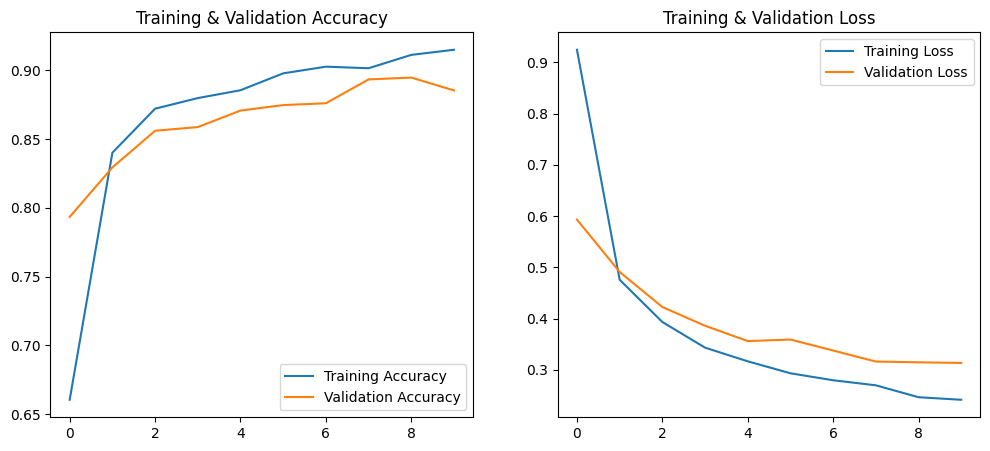

In [7]:
#visualizing accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
              precision    recall  f1-score   support

         ffx       0.89      0.82      0.85       150
         gow       0.86      0.85      0.86       150
         gt4       0.94      0.98      0.96       150
          kh       0.88      0.91      0.90       150
        sotc       0.92      0.93      0.93       150

    accuracy                           0.90       750
   macro avg       0.90      0.90      0.90       750
weighted avg       0.90      0.90      0.90       750

 
---
 


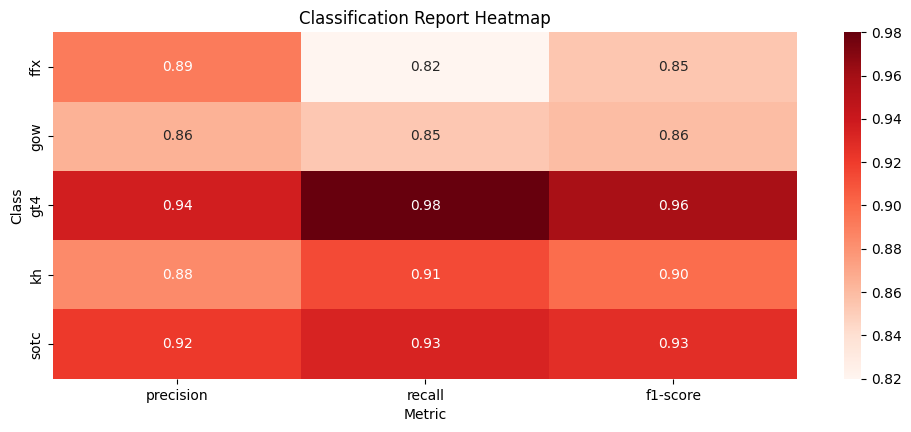

 
---
 

Global metrics:
              precision  recall  f1-score
accuracy        0.90000     0.9  0.900000
macro avg       0.89948     0.9  0.899279
weighted avg    0.89948     0.9  0.899279
 
---
 


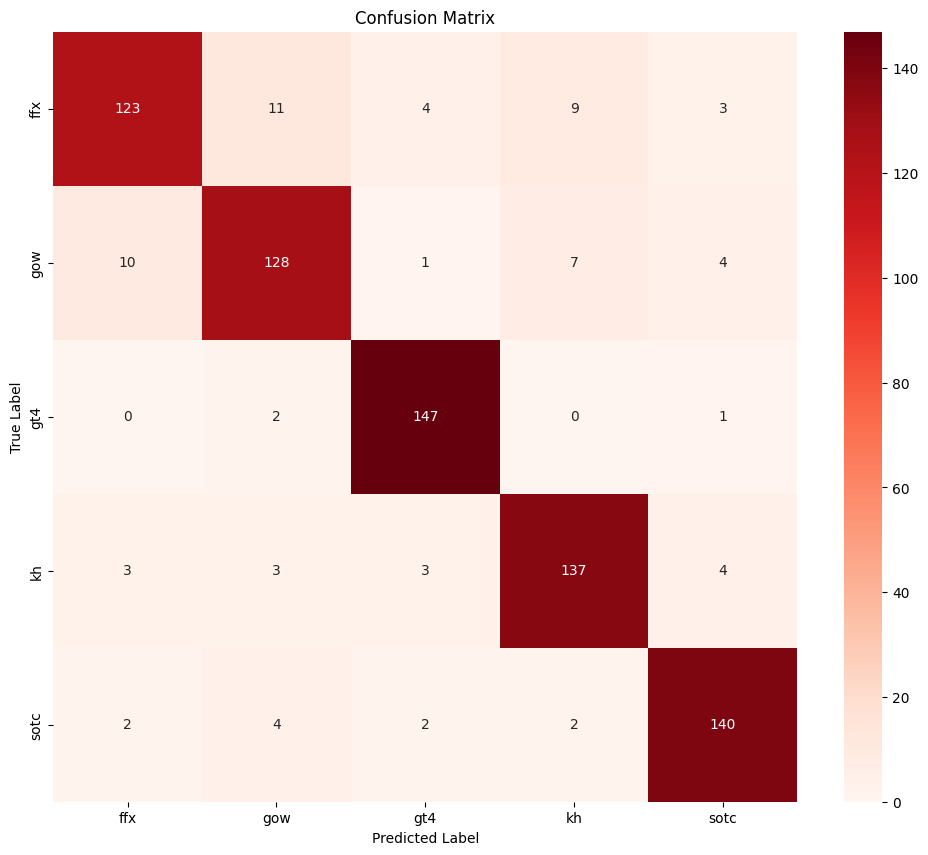

In [8]:
#predictions on test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

#classification report
print(classification_report(y_true, y_pred, target_names=class_names))
print(" ")
print("---")
print(" ")
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
#classes
report_df_classes = pd.DataFrame(report_dict).transpose()
report_df_classes_only = report_df_classes.iloc[:-3, :3]  #precision, recall and f1-score for each class
#global metrics
global_metrics = report_df_classes.iloc[-3:, :3]  #accuracy, macro avg, weighted avg

#visualizing classification report
plt.figure(figsize=(12, len(class_names)*0.5 + 2))
sns.heatmap(report_df_classes_only, annot=True, fmt=".2f", cmap="Reds", cbar=True)
plt.title("Classification Report Heatmap")
plt.ylabel("Class")
plt.xlabel("Metric")
plt.show()

print(" ")
print("---")
print(" ")

#global metrics
print("\nGlobal metrics:")
print(global_metrics)

print(" ")
print("---")
print(" ")

#confusion matrix
cm = confusion_matrix(y_true, y_pred)

#visualizing confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()